<a href="https://colab.research.google.com/github/JanLeyva/DeepLearning/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

--2021-10-24 10:38:25--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2021-10-24 10:38:25--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37cccaa6b28af13a778e58c90d.dl.dropboxusercontent.com/cd/0/inline/BYpDpYOLuYarQa9DBxoLVnyIgHj2UgCytg25lybAzfx7Af-PZrEU17ZaZ4koM4sFgqh5c2OqTIPNyz4EaDFpztMXif6Yx4f1SqcmbacF0n-gQHB--ULOBacSsF0oXW4qjK-MvRIgvz3iWcqdDPkhJioo/file# [following]
--2021-10-24 10:38:26--  https://uc37cccaa6b28af13a778e58c90d.dl.dropboxusercontent.com/cd/0/inline/BYpDpYOLuYarQa9DBxoLVnyIgHj2UgCytg25lybAzfx7Af-PZrEU17ZaZ4koM4sFgqh5c2OqTIPNyz4EaDFpztMXif6Yx4f1Sqcmba

In [2]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

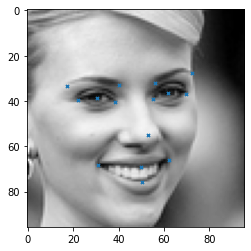

In [3]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [6]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                1105950   
Total params: 1,143,518
Trainable params: 1,143,518
Non-trainable params: 0
______________________________________________

In [7]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 32s 149ms/step - loss: 0.2576 - val_loss: 0.1256
Epoch 2/50
11/11 [==============================] - 1s 82ms/step - loss: 0.1174 - val_loss: 0.0861
Epoch 3/50
11/11 [==============================] - 1s 84ms/step - loss: 0.0820 - val_loss: 0.0701
Epoch 4/50
11/11 [==============================] - 1s 83ms/step - loss: 0.0683 - val_loss: 0.0639
Epoch 5/50
11/11 [==============================] - 1s 83ms/step - loss: 0.0614 - val_loss: 0.0557
Epoch 6/50
11/11 [==============================] - 1s 82ms/step - loss: 0.0549 - val_loss: 0.0516
Epoch 7/50
11/11 [==============================] - 1s 84ms/step - loss: 0.0485 - val_loss: 0.0540
Epoch 8/50
11/11 [==============================] - 1s 81ms/step - loss: 0.0445 - val_loss: 0.0426
Epoch 9/50
11/11 [==============================] - 1s 82ms/step - loss: 0.0392 - val_loss: 0.0414
Epoch 10/50
11/11 [==============================] - 1s 82ms/step - loss: 0.0366 - val_loss: 0.0405
Epoch 1

In [8]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Mean pixel error:  2.0412898


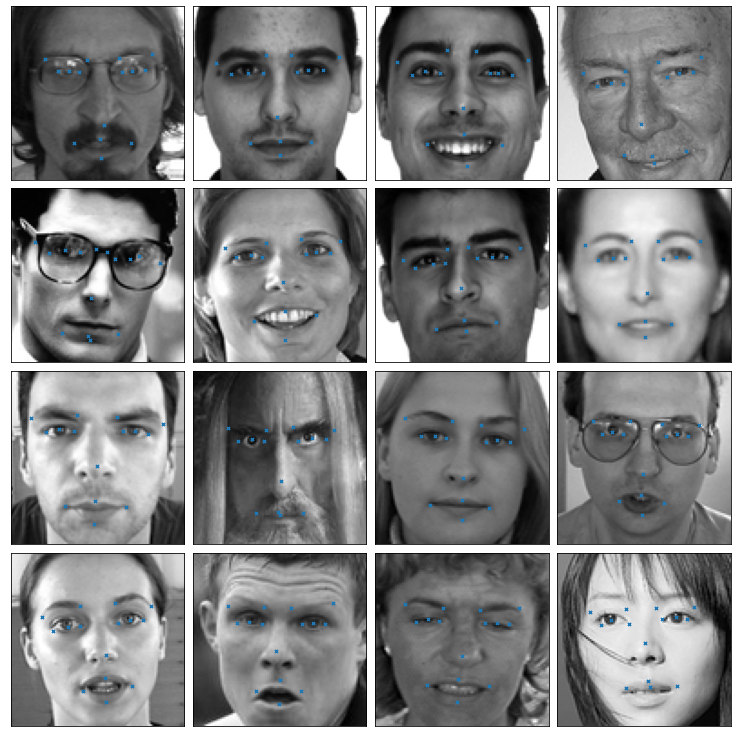

In [9]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

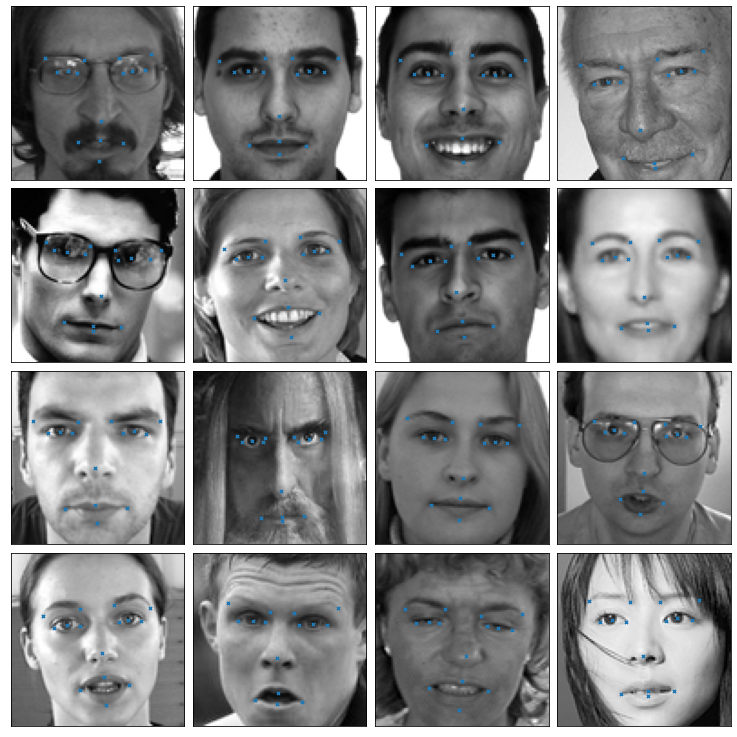

In [10]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: 

